In [49]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [50]:
!pip install japanize_matplotlib | tail -n 1
!pip install torchviz | tail -n 1
!pip install torchinfo | tail -n 1

In [51]:
import numpy as np
import glob
%matplotlib inline
import matplotlib.pyplot as plt
import japanize_matplotlib
from IPython.display import display

In [52]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.io import read_image

In [53]:
import pandas as pd

In [54]:
df = pd.read_table("/content/drive/MyDrive/expression/train_master.tsv")

In [55]:
def make_data_list():
    df_label = pd.read_table("/content/drive/MyDrive/expression/train_master.tsv")
    list_eyes = df_label["eyes"].tolist()
    list_filepath = df_label["id"].tolist()
    list_expression = df_label["expression"].tolist()
    list_pose = df_label["pose"].tolist()
    list_userid =df_label["userid"].tolist()
    return list_filepath, list_userid,list_pose, list_expression, list_eyes

list_filepath, list_userid, list_pose, list_expression, list_eyes = make_data_list()

In [56]:
from sklearn.model_selection import train_test_split

In [57]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])

In [58]:
import os.path as osp

In [59]:
import torch.utils.data as data

In [60]:
from PIL import Image

In [61]:
train_list_filepath, val_list_filepath, train_list_eyes, val_list_eyes = train_test_split(
    list_filepath,
    list_eyes,
    test_size = 0.25
    )

In [62]:
class Dataset(data.Dataset):
    def __init__(self, l_filepath, l_eyes, transform):
        self.filepath = l_filepath
        self.eyes = l_eyes
        self.transform = transform
    
    def __len__(self):
        return len(self.filepath)
    
    def __getitem__(self, index):
        rootpath = "/content/drive/MyDrive/expression"
        img_path = osp.join(rootpath, "train", self.filepath[index])
        img = Image.open(img_path)
        img_transformed = transform(img)
        
        label = self.eyes[index]
        if label == "open":
            label = 0
        else:
            label = 1
        
        return img_transformed, label




train_dataset = Dataset(
    l_filepath = train_list_filepath,
    l_eyes = train_list_eyes,
    transform = transform
)

val_dataset = Dataset(
    l_filepath = val_list_filepath,
    l_eyes = val_list_eyes,
    transform = transform
)
index = 6
print(train_dataset.__getitem__(index)[0].size())
print(train_dataset.__getitem__(index)[1])
print(val_dataset.__getitem__(index)[0].size())
print(val_dataset.__getitem__(index)[1])

torch.Size([1, 120, 128])
1
torch.Size([1, 120, 128])
1


In [63]:
BATCH_SIZE = 20

In [64]:
train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True,
    num_workers=0, 
    #drop_last=True,
)


test_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    num_workers=0, 
    #drop_last=True,
)

In [65]:
n_input = train_dataset.__getitem__(index)[0].view(-1).shape[0]

# 出力次元数
# 分類先クラス数　
n_output = 2

# 隠れ層のノード数
n_hidden = 5000

# 結果確認
print(f'n_input: {n_input}  n_hidden: {n_hidden} n_output: {n_output}')

n_input: 15360  n_hidden: 5000 n_output: 2


In [66]:
def eval_loss(train_loader, net, criterion):
  
    # データローダーから最初の1セットを取得する
    for image_transformed, labels in train_loader:
        break

    
    n_inputs = image_transformed
    labels = labels

    # 予測計算
    n_outputs = net(n_inputs)

    #  損失計算
    loss = criterion(n_outputs, labels)

    return loss

In [67]:
class CNN(nn.Module):
  def __init__(self, n_output, n_hidden):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 32, 3)
    self.conv2 = nn.Conv2d(32, 32, 3)
    self.relu = nn.ReLU(inplace=True)
    self.maxpool = nn.MaxPool2d((2,2))
    self.flatten = nn.Flatten()
    self.l1 = nn.Linear(115072, n_hidden)
    self.l2 = nn.Linear(n_hidden, n_output)

    self.features = nn.Sequential(
        self.conv1,
        self.relu,
        self.conv2,
        self.relu,
        self.maxpool)
    
    self.classifier = nn.Sequential(
       self.l1,
       self.relu,
       self.l2)

  def forward(self, x):
    x1 = self.features(x)
    x2 = self.flatten(x1)
    x3 = self.classifier(x2)
    return x3       

In [68]:
lr = 0.0001
net = CNN(n_output, n_hidden)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr)
history = np.zeros((0, 5))

In [69]:
# 学習用関数
def fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, history):

    # tqdmライブラリのインポート
    from tqdm.notebook import tqdm

    base_epochs = len(history)
  
    for epoch in range(base_epochs, num_epochs+base_epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0

        #訓練フェーズ
        net.train()
        count = 0

        for inputs, labels in tqdm(train_loader):
            count += len(labels)
           

            # 勾配の初期化
            optimizer.zero_grad()

            # 予測計算
            outputs = net(inputs)

            # 損失計算
            loss = criterion(outputs, labels)
            train_loss += loss.item()

            # 勾配計算
            loss.backward()

            # パラメータ修正
            optimizer.step()

            # 予測値算出
            predicted = torch.max(outputs, 1)[1]

            # 正解件数算出
            train_acc += (predicted == labels).sum().item()

            # 損失と精度の計算
            avg_train_loss = train_loss / count
            avg_train_acc = train_acc / count

        #予測フェーズ
        net.eval()
        count = 0

        for inputs, labels in test_loader:
            count += len(labels)
           

            # 予測計算
            outputs = net(inputs)

            # 損失計算
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # 予測値算出
            predicted = torch.max(outputs, 1)[1]

            # 正解件数算出
            val_acc += (predicted == labels).sum().item()

            # 損失と精度の計算
            avg_val_loss = val_loss / count
            avg_val_acc = val_acc / count
    
        print (f'Epoch [{(epoch+1)}/{num_epochs+base_epochs}], loss: {avg_train_loss:.5f} acc: {avg_train_acc:.5f} val_loss: {avg_val_loss:.5f}, val_acc: {avg_val_acc:.5f}')
        item = np.array([epoch+1, avg_train_loss, avg_train_acc, avg_val_loss, avg_val_acc])
        history = np.vstack((history, item))
    return history

In [70]:
num_epochs = 50
history = fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, history)

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [1/50], loss: 0.03560 acc: 0.47863 val_loss: 0.03556, val_acc: 0.50427


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [2/50], loss: 0.03554 acc: 0.50855 val_loss: 0.03551, val_acc: 0.50427


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [3/50], loss: 0.03551 acc: 0.50855 val_loss: 0.03547, val_acc: 0.50855


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [4/50], loss: 0.03546 acc: 0.50000 val_loss: 0.03543, val_acc: 0.52137


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [5/50], loss: 0.03542 acc: 0.54701 val_loss: 0.03539, val_acc: 0.52137


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [6/50], loss: 0.03540 acc: 0.50855 val_loss: 0.03535, val_acc: 0.58547


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [7/50], loss: 0.03534 acc: 0.60256 val_loss: 0.03531, val_acc: 0.57265


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [8/50], loss: 0.03532 acc: 0.58974 val_loss: 0.03527, val_acc: 0.61966


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [9/50], loss: 0.03530 acc: 0.54274 val_loss: 0.03523, val_acc: 0.70513


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [10/50], loss: 0.03524 acc: 0.69658 val_loss: 0.03520, val_acc: 0.70513


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [11/50], loss: 0.03521 acc: 0.65385 val_loss: 0.03516, val_acc: 0.72650


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [12/50], loss: 0.03516 acc: 0.75214 val_loss: 0.03513, val_acc: 0.69658


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [13/50], loss: 0.03514 acc: 0.65812 val_loss: 0.03509, val_acc: 0.71368


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.03511 acc: 0.69231 val_loss: 0.03506, val_acc: 0.76923


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.03508 acc: 0.73077 val_loss: 0.03503, val_acc: 0.71795


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.03505 acc: 0.74359 val_loss: 0.03499, val_acc: 0.75214


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.03500 acc: 0.70513 val_loss: 0.03496, val_acc: 0.76496


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.03498 acc: 0.76496 val_loss: 0.03493, val_acc: 0.69658


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.03495 acc: 0.59829 val_loss: 0.03489, val_acc: 0.76923


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.03490 acc: 0.75214 val_loss: 0.03486, val_acc: 0.77350


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.03488 acc: 0.74359 val_loss: 0.03483, val_acc: 0.77778


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.03484 acc: 0.77350 val_loss: 0.03479, val_acc: 0.78632


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.03481 acc: 0.71368 val_loss: 0.03476, val_acc: 0.81197


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.03476 acc: 0.80769 val_loss: 0.03473, val_acc: 0.80769


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.03476 acc: 0.78632 val_loss: 0.03470, val_acc: 0.79060


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.03471 acc: 0.76923 val_loss: 0.03467, val_acc: 0.80769


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.03467 acc: 0.83333 val_loss: 0.03464, val_acc: 0.76068


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.03467 acc: 0.74786 val_loss: 0.03461, val_acc: 0.75641


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.03463 acc: 0.77350 val_loss: 0.03458, val_acc: 0.75641


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.03458 acc: 0.74359 val_loss: 0.03455, val_acc: 0.76923


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.03459 acc: 0.79487 val_loss: 0.03452, val_acc: 0.79060


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.03453 acc: 0.79060 val_loss: 0.03449, val_acc: 0.82479


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.03449 acc: 0.82479 val_loss: 0.03446, val_acc: 0.79915


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.03445 acc: 0.79060 val_loss: 0.03443, val_acc: 0.77350


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.03445 acc: 0.75214 val_loss: 0.03440, val_acc: 0.81624


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.03440 acc: 0.80769 val_loss: 0.03437, val_acc: 0.79915


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.03439 acc: 0.81197 val_loss: 0.03434, val_acc: 0.82906


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.03436 acc: 0.78205 val_loss: 0.03431, val_acc: 0.83761


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.03432 acc: 0.82479 val_loss: 0.03428, val_acc: 0.83333


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.03427 acc: 0.83761 val_loss: 0.03425, val_acc: 0.83333


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.03426 acc: 0.78205 val_loss: 0.03422, val_acc: 0.84188


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.03423 acc: 0.82906 val_loss: 0.03419, val_acc: 0.84615


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.03423 acc: 0.81197 val_loss: 0.03416, val_acc: 0.84615


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.03419 acc: 0.82906 val_loss: 0.03413, val_acc: 0.82906


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.03416 acc: 0.83333 val_loss: 0.03411, val_acc: 0.84615


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.03410 acc: 0.83761 val_loss: 0.03408, val_acc: 0.83333


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.03410 acc: 0.79915 val_loss: 0.03405, val_acc: 0.85043


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.03406 acc: 0.84188 val_loss: 0.03402, val_acc: 0.81197


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.03400 acc: 0.82479 val_loss: 0.03399, val_acc: 0.81197


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.03399 acc: 0.80342 val_loss: 0.03396, val_acc: 0.82479


In [71]:
def evaluate_history(history):
    #損失と精度の確認
    print(f'初期状態: 損失: {history[0,3]:.5f} 精度: {history[0,4]:.5f}') 
    print(f'最終状態: 損失: {history[-1,3]:.5f} 精度: {history[-1,4]:.5f}' )

    num_epochs = len(history)
    unit = num_epochs / 10

    # 学習曲線の表示 (損失)
    plt.figure(figsize=(9,8))
    plt.plot(history[:,0], history[:,1], 'b', label='訓練')
    plt.plot(history[:,0], history[:,3], 'k', label='検証')
    plt.xticks(np.arange(0,num_epochs+1, unit))
    plt.xlabel('繰り返し回数')
    plt.ylabel('損失')
    plt.title('学習曲線(損失)')
    plt.legend()
    plt.show()

    # 学習曲線の表示 (精度)
    plt.figure(figsize=(9,8))
    plt.plot(history[:,0], history[:,2], 'b', label='訓練')
    plt.plot(history[:,0], history[:,4], 'k', label='検証')
    plt.xticks(np.arange(0,num_epochs+1,unit))
    plt.xlabel('繰り返し回数')
    plt.ylabel('精度')
    plt.title('学習曲線(精度)')
    plt.legend()
    plt.show()

初期状態: 損失: 0.03556 精度: 0.50427
最終状態: 損失: 0.03396 精度: 0.82479


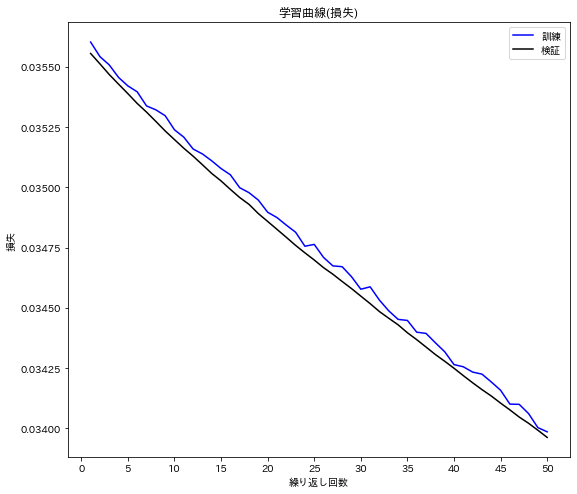

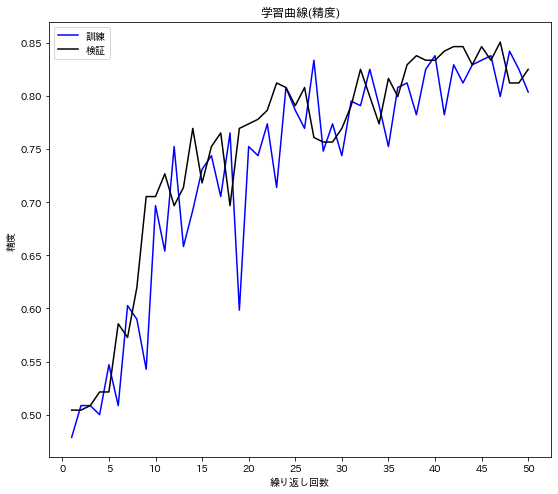

In [72]:
evaluate_history(history)